In [2]:
import numpy as np
import pandas as pd
import os

def signature_distance(sig_a, sig_b):
    """计算两个签名向量之间的欧氏距离平方"""
    return np.dot(sig_a, sig_a) - 2 * np.dot(sig_a, sig_b) + np.dot(sig_b, sig_b)

def compute_adaptive_weights(time_window=10, order=3, gamma=1.0, 
                              input_filename='sig_data_SP500', 
                              save=True):
    """
    加载签名特征数据，计算每只股票的自适应权重，并保存结果。
    
    参数:
    time_window (int): 用于文件路径识别的窗口大小（需与签名计算时一致）
    order (int): 签名阶数（需与签名计算时一致）
    gamma (float): 权重衰减因子
    input_filename (str): 输入文件基础名（不包含后缀）
    save (bool): 是否保存带权重的结果
    
    返回:
    pd.DataFrame: 含自适应权重的签名数据
    """
    # 构造输入文件路径
    input_path = f"./datasets/{input_filename}_w{time_window}_o{order}.parquet"
    print(f"加载签名特征数据: {input_path}")
    
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"未找到文件: {input_path}")
    
    df = pd.read_parquet(input_path)

    # 自动识别签名列
    sig_cols = [col for col in df.columns if col.startswith('SIG_')]
    print(f"识别到 {len(sig_cols)} 个签名特征列")

    # 初始化
    df = df.sort_values(['symbol', 'date']).copy()
    df['adaptive_weight'] = np.nan

    def compute_weights_for_symbol(group):
        group = group.copy()
        if len(group) < 2:
            return group
        
        # 使用最后一行作为参考点
        current_sig = group[sig_cols].iloc[-1].values
        
        distances = group[sig_cols].iloc[:-1].apply(
            lambda row: signature_distance(row.values, current_sig),
            axis=1
        )
        exp_weights = np.exp(-gamma * distances)
        normalized_weights = exp_weights / exp_weights.sum()
        
        group.loc[group.index[:-1], 'adaptive_weight'] = normalized_weights.values
        return group

    # 对每支股票分组计算
    df = df.groupby('symbol', group_keys=False).apply(compute_weights_for_symbol)

    print(f"完成权重计算，共处理 {df['symbol'].nunique()} 支股票样本")

    if save:
        output_path = f"./datasets/{input_filename}_w{time_window}_o{order}_weighted_gamma{gamma}.parquet"
        df.to_parquet(output_path, engine='pyarrow', compression='snappy')
        print(f"结果已保存至: {output_path}")
    
    return df

# 示例调用
if __name__ == "__main__":
    # 请确保这里的参数与 `calc_signature_new()` 使用的一致
    weighted_df = compute_adaptive_weights(
        time_window=10,
        order=3,
        gamma=0.5,
        input_filename='sig_data_SP500',
        save=True
    )


加载签名特征数据: ./datasets/sig_data_SP500_w10_o3.parquet
识别到 40 个签名特征列


/var/folders/3r/3sqtmq0x51z9_1w597p8dg6w0000gn/T/ipykernel_93797/3310137381.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('symbol', group_keys=False).apply(compute_weights_for_symbol)


完成权重计算，共处理 480 支股票样本
结果已保存至: ./datasets/sig_data_SP500_w10_o3_weighted_gamma0.5.parquet


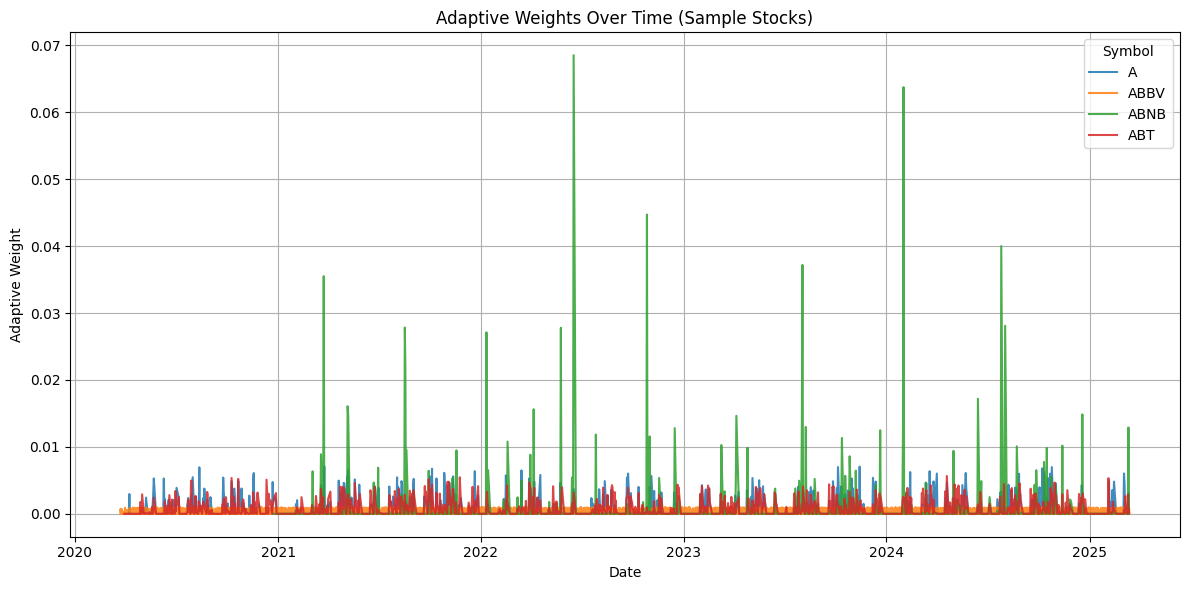

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
plot_df = weighted_df.dropna(subset=["adaptive_weight"]).copy()
plot_df["date"] = pd.to_datetime(plot_df["date"])
plot_df.sort_values(["symbol", "date"], inplace=True)

# 2. Time series of adaptive weights for sample stocks
sample_stocks = plot_df["symbol"].unique()[:4]  # pick 4 sample stocks
plt.figure(figsize=(12, 6))
for stock in sample_stocks:
    stock_data = plot_df[plot_df["symbol"] == stock]
    plt.plot(stock_data["date"], stock_data["adaptive_weight"], label=stock, alpha=0.85)

plt.title("Adaptive Weights Over Time (Sample Stocks)")
plt.xlabel("Date")
plt.ylabel("Adaptive Weight")
plt.legend(title="Symbol")
plt.grid(True)
plt.tight_layout()
plt.show()
